### Imports

In [1]:
%cd ..

/home/ds/DataScience/home/ademyanchuk/Projects/ulmfit-multilingual


In [2]:
!pwd

/home/ds/DataScience/home/ademyanchuk/Projects/ulmfit-multilingual


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.text import *

In [5]:
from ulmfit.pretrain_lm import *

In [6]:
cuda_id = 1
torch.cuda.set_device(cuda_id)

### Preparing data

In [7]:
# batch size
bs = 30

In [8]:
# use data from smaller sample of wiki
# data is recieved through prepare_wiki.sh script
wiki_data_path = Path('data/wiki/ru-100-unk/')

In [9]:
wiki_data_path.ls()

[PosixPath('data/wiki/ru-100-unk/ru.wiki.test.tokens'),
 PosixPath('data/wiki/ru-100-unk/ru.wiki.valid.tokens'),
 PosixPath('data/wiki/ru-100-unk/ru.wiki.train.tokens'),
 PosixPath('data/wiki/ru-100-unk/models'),
 PosixPath('data/wiki/ru-100-unk/tmp_lm'),
 PosixPath('data/wiki/ru-100-unk/ru.wiki.train.tokens.temp')]

In [11]:
# provide train and valid path
trn_path = wiki_data_path/'ru.wiki.train.tokens'
val_path = wiki_data_path/'ru.wiki.valid.tokens'

In [12]:
# create a databunch object from data_frames
# data_frames are provided through `read_wiki_articles` function
# from `ulmfit.pretrain_lm`
data_lm = TextLMDataBunch.from_df(path=wiki_data_path, train_df=read_wiki_articles(trn_path),
                                  valid_df=read_wiki_articles(val_path), 
                                  classes=None, bs=bs, text_cols='texts')

In [13]:
itos = data_lm.vocab.itos
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', itos[:20])

Size of vocabulary: 60003
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', ',', '.', 'в', 'и', '\n \n ', 'на', ')', '(', '\n ', '—', '«', '»']


In [14]:
len(data_lm.train_ds), len(data_lm.valid_ds)

(189786, 447)

In [15]:
data_lm.train_ds[0][0]

Text xxbos = xxmaj розовая чайка = 
  xxmaj розовая чайка 
 
  xxmaj розовая чайка ( ) — вид птиц из семейства xxunk ( xxmaj xxunk ) , единственный в роде xxunk xxunk ( & ' xxmaj xxunk & ' ) . 
 
  xxmaj описание . 
  xxmaj длина тела около 35 см . xxmaj спина и верх крыльев серо - xxunk , голова , грудь и брюшко розовые , на шее узкий чёрный xxunk . xxmaj клюв чёрный , ноги красные . xxmaj хвост xxunk формы . 
 
  xxmaj полёт розовой чайки лёгкий , напоминающий полёт xxunk . xxmaj по отношению к человеку птица обычно мало xxunk и xxunk . xxmaj на море она главным образом держится на плавающих xxunk , а вот в xxunk , на озёрах , чайка часто садится на воду и даже xxunk . 
 
  xxmaj xxunk . 
  xxmaj голос этого вида гораздо выше и xxunk , чем у других xxunk , и отличается большим разнообразием . xxmaj чаще всего xxunk крик вроде « э - у , э - у » ; xxunk , они издают короткий крик « xxunk , xxunk , xxunk » , если очень xxunk — « xxunk - xxunk » , а при нападении другой чайки того же вид

In [11]:
data_lm.show_batch()

idx,text
0,"xxbos \n = xxmaj xxunk , xxmaj фриц = \n xxmaj xxunk , xxmaj фриц \n \n xxmaj фриц xxmaj xxunk ( ; 18 июля 1910 , , xxmaj германская империя — дата смерти неизвестна ) — xxunk xxup сс , руководитель xxunk xxunk , xxunk массовые убийства на xxmaj украине , сотрудник xxup xxunk . \n \n xxmaj биография . \n xxmaj его братом"
1,"xxmaj после xxunk обратного свода , укладки пути , xxunk и подключения коммуникаций новый xxmaj xxunk тоннель был введён в эксплуатацию . xxmaj сдача тоннеля в эксплуатацию состоялась 25 декабря 2012 года . \n \n xxmaj считается , что строительство нового тоннеля позволит резко увеличить объём железнодорожных перевозок на xxmaj восточном xxunk направлением на xxmaj xxunk и xxmaj советскую xxmaj гавань — с 12 млн т в 2009 году"
2,"скульпторы , такие , как xxmaj xxunk , xxmaj xxunk , xxmaj xxunk и многие другие , увидев xxmaj xxunk , просили его xxunk им . xxmaj георг был также любимой моделью известного эстонского скульптора xxmaj xxunk xxmaj xxunk , выпускника xxmaj петербургской xxmaj академии художеств . xxmaj одна из их совместных работ — « xxmaj чемпион » — была удостоена первой премии на всемирной выставке 1904 года в xxmaj"
3,"xxmaj грузии xxmaj михаил xxmaj саакашвили в своём xxunk заявил об « освобождении » xxunk структурами xxmaj грузии xxmaj xxunk и xxmaj xxunk районов , сел xxmaj xxunk , xxmaj xxunk и xxmaj xxunk , а также большей части xxmaj xxunk . xxmaj он обвинил xxmaj россию в бомбардировке территории xxmaj грузии , назвав это « классической международной xxunk » . \n \n xxmaj утром 9 августа помощник главкома"
4,"1803 году местное население составляло от 5 до 10 тысяч человек . xxmaj из - за xxunk европейцами инфекционных заболеваний , к которым у аборигенов не было иммунитета , войны и преследований коренное население острова сократилось к 1833 году до 300 человек . xxmaj почти все аборигены были переселены xxmaj джорджем xxmaj августом xxmaj xxunk на остров xxmaj xxunk . \n \n xxmaj женщина по имени xxmaj xxunk ("


In [17]:
# save databunch
data_lm.save('tmp_lm')

In [10]:
# load databunch
data_lm = TextLMDataBunch.load(wiki_data_path, 'tmp_lm', bs=bs)

#### Create Learner and train Language Model

In [12]:
# create learner for training on wiki from scratch
learner = language_model_learner(data=data_lm, drop_mult=1.0)

In [13]:
learner.load('ru-100-unk-best')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (189786 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/wiki/ru-100-unk
x: LMTextList (189786 items)
[Text xxbos = xxmaj розовая чайка = 
  xxmaj розовая чайка 
 
  xxmaj розовая чайка ( ) — вид птиц из семейства xxunk ( xxmaj xxunk ) , единственный в роде xxunk xxunk ( & ' xxmaj xxunk & ' ) . 
 
  xxmaj описание . 
  xxmaj длина тела около 35 см . xxmaj спина и верх крыльев серо - xxunk , голова , грудь и брюшко розовые , на шее узкий чёрный xxunk . xxmaj клюв чёрный , ноги красные . xxmaj хвост xxunk формы . 
 
  xxmaj полёт розовой чайки лёгкий , напоминающий полёт xxunk . xxmaj по отношению к человеку птица обычно мало xxunk и xxunk . xxmaj на море она главным образом держится на плавающих xxunk , а вот в xxunk , на озёрах , чайка часто садится на воду и даже xxunk . 
 
  xxmaj xxunk . 
  xxmaj голос этого вида гораздо выше и xxunk , чем у других xxunk , и отличается большим разнооб

In [14]:
# change Adam default params
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [15]:
learner.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.8, 0.99))

In [16]:
learner.metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.LongTensor) -> <function NewType.<locals>.new_type at 0x7fb0d165cf28>>]

In [17]:
# add save callback
learner.callback_fns += [partial(SaveModelCallback, every='epoch', name='lm')]

In [18]:
learner.callback_fns

[fastai.basic_train.Recorder,
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, every='epoch', name='lm')]

In [19]:
# unfreeze all layers
learner.unfreeze()

In [25]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


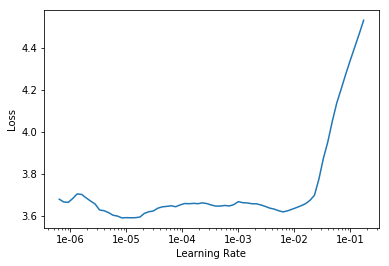

In [26]:
learner.recorder.plot(skip_end=15)

In [22]:
# define non-default momentums
moms=(0.8,0.7)

In [23]:
learner.fit_one_cycle(4, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,3.650695,3.406265,0.428821
2,3.780002,3.396528,0.429244
3,3.829076,3.364912,0.435912
4,3.584365,3.340251,0.439377


In [24]:
# save model
learner.save('ru-100-unk-best')

In [ ]:
# cell to restart notebook kernel from within
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

### Fine tune on ruSentiment

http://text-machine.cs.uml.edu/projects/rusentiment/

In [8]:
# path for ruSentiment data
rusent_data_path = Path('data/ruSentiment/')

In [10]:
bs = 48

In [9]:
rusent_data_path.ls()

[PosixPath('data/ruSentiment/rusentiment_random_posts.csv'),
 PosixPath('data/ruSentiment/rusentiment_test.csv'),
 PosixPath('data/ruSentiment/rusentiment_preselected_posts.csv')]

In [11]:
# create LM DataBunch from csv which is done by `merge-and-sample-rusent.ipynb`
data1_lm = TextLMDataBunch.from_csv(rusent_data_path, 'rusentiment_random_posts.csv', bs=bs)

In [12]:
itos, stoi, data_path = data1_lm.vocab.itos, data1_lm.vocab.stoi, data1_lm.path
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', itos[:20])
print(str(data_path))

Size of vocabulary: 8717
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', ',', '!', ')', '.', '\n', 'и', 'в', '-', 'не', 'с', 'я', '?']
data/ruSentiment


In [18]:
(data1_lm.path).ls()

[PosixPath('data/ruSentiment/models'),
 PosixPath('data/ruSentiment/tmp_lm'),
 PosixPath('data/ruSentiment/rusentiment_random_posts.csv'),
 PosixPath('data/ruSentiment/rusentiment_test.csv'),
 PosixPath('data/ruSentiment/rusentiment_preselected_posts.csv')]

In [14]:
len(data1_lm.train_ds), len(data1_lm.valid_ds)

(17014, 4254)

In [15]:
data1_lm.show_batch()

idx,text
0,xxbos xxmaj все девушки козлы ! и от мужчин им нужен только секс ! =) xxbos ну xxunk xxunk xxbos xxunk : * xxbos xxmaj через 10 дней . \n xxmaj поезд xxmaj херсон xxunk . \n xxunk на xxunk . xxbos xxmaj саня ! ! ! с xxmaj днем xxmaj рождения ! xxbos посты ниже порадовали xxunk xxbos xxmaj угадай кто на фото ) ) xxbos с днем рождения
1,"а там он , xxunk , теплый и xxunk xxunk , что ты холодная . xxbos с днём рождения xxrep 5 ) xxbos xxunk позитива перед xxunk xxunk xxrep 7 . xxrep 7 ) xxbos xxmaj вот так у нас проходит математика ; ) xxbos xxmaj дорогие xxmaj друзья ! ! ! подписывайтесь на xxmaj наш xxunk \n\n\n\n приятного прослушивания ! \n\n xxmaj спасибо за максимальный xxup репост записи !"
2,"знаю , где твое самое xxunk место на свете . — xxmaj где ? — xxmaj за моей спиной .. xxbos у меня очень мало xxunk : ежедневно 30 минут xxunk xxunk спортом ( это не много , xxunk хорошо выглядеть ) , xxunk xxunk кофе ( обязательно со xxunk ) утром , читать сказку дочке на ночь с xxup xxunk , xxunk в xxunk , xxunk на 10 минут"
3,"погулял xxup по - xxup русски ) ) xxbos xxmaj ты очень красивый ... и губы , губы .. ! ! : * : * xxbos xxunk , интересный xxunk оч xxunk xxunk ! ; ) xxbos xxmaj не ищите xxunk , не ищите красивых , а ищите xxunk и навеки любимых … xxmaj не ищите xxunk , не ищите "" xxunk "" и тогда вы xxunk , своих …"
4,"не предлагать ;) xxbos я буду скучать ... xxbos xxup максим xxup xxunk xxup xxunk в xxup бассейн ? \n\n ещё как ) \n xxbos с днем рождения , xxunk , счастья и успеха ! 🎉 🎉 🎉 xxbos xxmaj смешной кот xxbos xxmaj xxunk - xxunk xxunk украинского протеста xxbos xxmaj xxunk xxunk ? ? ) ) xxbos xxmaj какой коктейль вам не нравится ? ? ? xxbos xxup"


In [17]:
# save data bunch 
data1_lm.save('tmp_lm')

In [10]:
data1_lm = TextLMDataBunch.load(rusent_data_path, 'tmp_lm', bs=bs)

#### Create Learner and Finetune model from pretrained fnames

In [19]:
# pretrained model and vocab from first step of training LM
pretrained_fnames = ['ru-2-best', 'itos']

In [20]:
# create learner and provide pretrained files to finetune wiki-LM with ruSentiment data
learner = language_model_learner(data1_lm, pretrained_fnames=pretrained_fnames, drop_mult=0.3)

Unknown tokens 2989, first 100: ['"', ':)', '♥', 'поздравляю', '❤', '😊', '😘', '=)', '️', ':d', 'vk.com', 'скучаю', '😂', 'твои', 'наилучшего', ';)', '😍', '💋', 'рожденья', '🎁', 'днюхой', '🎉', '©', '😉', 'блин', '😚', '😃', '😆', 'любишь', 'народження', 'посмотри', 'пиздец', '🎂', 'бля', 'твоих', 'днюшкой', 'благ', '►', 'солнышко', '\n \n', '☺', 'пускай', 'оставайся', 'прям', 'жду', 'нахуй', ':3', 'побольше', ':*', 'мужик', 'куплю', 'счастлива', 'сука', '🎈', 'крепкого', 'блять', '💖', '😎', 'варенья', '😄', 'помнишь', 'p.s.', 'узнай', 'ахаха', 'приветик', 'братан', 'весело', 'милая', 'прости', 'репост', 'помогите', 'хуй', 'поздравления', 'грн', '👍', 'эх', 'ахах', 'пожелать', '✌', 'безумно', 'ахахах', 'поздравить', 'будьте', 'чувак', '🌷', '😜', '\xa0', 'чё', 'иди', ':)))', 'смотрю', 'ищу', 'ето', 'поздравляем', 'обожаю', ':))', 'рождеством', 'счастливой', 'бро', ':(']


In [22]:
learner.callback_fns += [partial(SaveModelCallback, every='epoch', name='lm')]

In [21]:
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [22]:
learner.metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.LongTensor) -> <function NewType.<locals>.new_type at 0x7f8a91b5bf28>>]

In [23]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


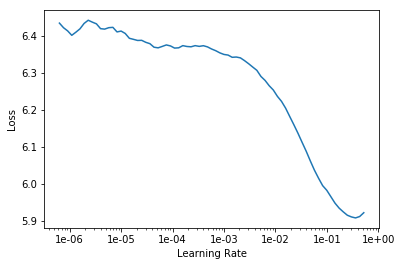

In [24]:
learner.recorder.plot(skip_end=15)

In [25]:
moms = (0.8, 0.7)

In [26]:
# learning the same way as in fastai v1 examples
learner.fit_one_cycle(1, 3e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,4.755524,4.265546,0.280021


In [27]:
learner.save('fit_head')

In [28]:
learner.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (17014 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/ruSentiment
x: LMTextList (17014 items)
[Text xxbos xxmaj итак 
 xxmaj короче 
 xxmaj мудила xxunk ) 
 я поздравляю тебя с твоим xxunk , возрастом боли и xxunk ) 
 xxmaj желаю тебе , чтобы у тебя появилась xxunk , собака , чтоб ты свалил в xxmaj xxunk , там xxunk группу xxunk - xxunk , а потом свалил , например , в германию ) ) 
 xxmaj ну и сейчас чтобы нашел какую - нибудь нормальную , в меру xxunk мозг xxunk , которая бы тебя любила ) 
 xxmaj вот ), Text xxbos xxmaj xxunk полиции xxunk лучших в xxunk без оружия - xxmaj xxunk " xxmaj xxunk ", Text xxbos xxmaj вы опять xxunk xxunk ) ) делать не хуй что ли стало ?, Text xxbos xxmaj друзья xxunk в беде xxrep 4 ., Text xxbos xxmaj красивой , нежной и веселой 
 xxmaj очаровательной , xxunk , 
 xxmaj всегда любимой и xxunk , 
 xxmaj душою вечно молодой , 
 с огнем в груди , 
 с xxunk в с

In [29]:
learner.unfreeze()

In [30]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


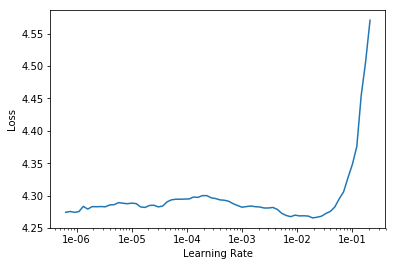

In [31]:
learner.recorder.plot(skip_end=15)

In [32]:
learner.fit_one_cycle(10, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,4.257998,4.212062,0.286961
2,4.180362,4.124466,0.298159
3,4.077897,4.061832,0.305724
4,3.949593,4.023438,0.309089
5,3.829355,4.004425,0.310196
6,3.725506,3.993174,0.313259
7,3.613018,3.999811,0.312865
8,3.542066,4.004945,0.313406
9,3.501789,4.005034,0.312803
10,3.481090,4.008079,0.312818


In [33]:
# save fine_tuned model
learner.save('fine_tuned')

In [34]:
# check text generation with LM
TEXT = "сегодня утром я"
N_WORDS = 10
N_SENTENCES = 2

In [35]:
print("\n".join(learner.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

сегодня утром я ожидает заполнять телешоу надоели страшных чудная тот символ xd отвечаю
сегодня утром я мысленно здорова зайти забирает 😇 роль варить 2012 останутся сплетни


In [36]:
# save finetuned models encoder to use for classification task
learner.save_encoder('fine_tuned_enc')

### Classifier

In [37]:
rusent_data_path.ls()

[PosixPath('data/ruSentiment/models'),
 PosixPath('data/ruSentiment/tmp_lm'),
 PosixPath('data/ruSentiment/rusentiment_random_posts.csv'),
 PosixPath('data/ruSentiment/rusentiment_test.csv'),
 PosixPath('data/ruSentiment/rusentiment_preselected_posts.csv')]

In [ ]:
# TODO: change databunch creation to use test.csv for validation

In [48]:
# create classification databunch, please note usage of LM vocab
data_clas = TextClasDataBunch.from_csv(path=rusent_data_path, csv_name='rusentiment_random_posts.csv',
                                       test='rusentiment_test.csv',
                                       vocab=data1_lm.vocab, text_cols='text', label_cols='label', bs=bs)

In [56]:
data_clas.show_batch()

text,target
"xxbos - xxmaj отдать тебе любовь ? \n - xxmaj отдай . \n - xxmaj она в грязи . \n - xxmaj отдай в грязи . \n - я xxunk хочу . \n - xxmaj xxunk \n - xxmaj еще спросить хочу . \n - xxmaj спроси . \n - xxmaj допустим , xxunk . \n - xxmaj xxunk . \n - xxmaj допустим , xxunk . \n - xxmaj",neutral
"xxbos xxrep 18 _ @;@ , \n _ _ _ , xxunk / ) @;@ ; \n _ _ , ; xxunk _ / @ xxunk .. e \ \n _ ( xxunk \ xxunk ( _ _ \ \n _ _ ' xxunk ' \n _ _ _ ' @;@ ; / ; @ ; / ; @ ; ' \n xxrep 5 _ ) / / _",speech
xxbos в xxup xxunk xxup состоянии xxup сложно xxup произнести : \n 1 . xxmaj xxunk . \n 2 . xxmaj xxunk . \n 3 . xxmaj xxunk . \n 4 . xxmaj xxunk . \n xxup очень xxup сложно xxup произнести : \n 1 . xxmaj xxunk . \n 2 . xxmaj xxunk . \n 3 . xxmaj xxunk . \n 4 . xxmaj xxunk . \n и xxup,skip
"xxbos xxmaj быть может я вернусь домой , \n xxmaj на радость xxunk xxunk . \n и чтобы грусть xxunk долой , \n xxmaj xxunk немного xxunk , \n xxmaj по старой xxunk xxunk . \n и на xxunk xxunk , \n xxmaj из "" xxunk "" магазина \n xxmaj ты выйдешь ... xxmaj xxunk лицо \n xxmaj xxunk к xxunk пива ... \n xxmaj на xxunk вижу я кольцо",negative
"xxbos « – xxmaj эй , что xxunk ? – xxunk его xxmaj кенет . – xxmaj уходить не хочется ? \n – xxmaj да не в том дело , – xxunk xxmaj кэссин . – xxmaj просто я себя чувствую … даже и сам не знаю кем . xxmaj очень хочется поступить правильно … вот только не знаю , как это – правильно . \n – xxmaj не знаешь",neutral


In [58]:
# number of classes
data_clas.train_ds.c

5

In [59]:
data_clas.train_ds.classes

['negative', 'neutral', 'positive', 'skip', 'speech']

In [61]:
data_clas

TextClasDataBunch;

Train: LabelList
y: CategoryList (17014 items)
[Category positive, Category negative, Category skip, Category neutral, Category neutral]...
Path: data/ruSentiment
x: TextList (17014 items)
[Text xxbos xxup удачи xxup на xxup xxunk xxup xxunk ) ), Text xxbos 
 xxmaj ребята мы ведь можем по 4 часа в день xxunk . нас xxunk используют . xxmaj платят xxunk xxunk или совсем забывают xxunk ., Text xxbos xxmaj купил 5 кг xxunk , хочется xxunk ... ;) © xxmaj xxunk, Text xxbos xxmaj давай встречаться без разрешения xxmaj xxunk ?, Text xxbos xxmaj помогите , пожалуйста , я не знаю , как правильно поступить в такой ситуации , честно говоря , никогда не xxunk : вчера семья из трех человек : мама , папа и ребенок 4-х лет пытались xxunk со стороны xxmaj xxunk - xxmaj xxunk - xxmaj xxunk , но , увы , не смогли , родители xxunk , водитель автомобиля тоже , а девочка осталась xxunk , ей 4 годика , в настоящий момент после xxunk она находится в xxmaj xxunk xxunk , xxunk нет , ее xxup 

In [63]:
len(data_clas.vocab.itos)

8717

In [62]:
# save for future use
data_clas.save('tmp_clas')

In [27]:
data_clas = TextClasDataBunch.load(rusent_data_path, 'tmp_clas', bs=bs)

In [76]:
# create learner and train
# train classifier as in fastai imdb example
learner = text_classifier_learner(data=data_clas, drop_mult=0.5)

In [77]:
# load fine tuned encoder
learner.load_encoder('fine_tuned_enc')

In [78]:
learner.freeze()

In [79]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


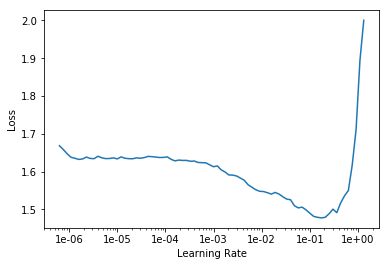

In [80]:
learner.recorder.plot()

In [69]:
moms=(0.8,0.7)


In [81]:
learner.fit_one_cycle(3, 1e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,1.184045,1.175444,0.540197
2,1.123152,1.127263,0.536201
3,1.103971,1.075097,0.556182


In [82]:
learner.save('first')

In [38]:
learner.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (204089 items)
[Category positive, Category positive, Category positive, Category positive, Category positive]...
Path: .
x: TextList (204089 items)
[Text xxbos xxunk хоть я и школота , но поверь , у нас то же самое xxup :d общество xxunk предмет типа ), Text xxbos xxmaj да , все - таки он немного похож на него . xxmaj но мой мальчик все равно лучше : d, Text xxbos xxup rt xxunk : xxmaj ну ты идиотка ) я испугалась за тебя ! ! !, Text xxbos xxup rt xxunk : " xxmaj кто то в углу сидит и погибает от голода , а мы ещё 2 порции взяли , хотя уже и так жрать не хотим " : xxup dd http : / / t.co / xxunk …, Text xxbos xxunk xxmaj вот что значит xxunk xxup :d 
 xxmaj но блин , посмотрев все части , у тебя xxunk ощущение , что авторы курили что - то xxup :d]...
Path: data/ruSentEval;

Valid: LabelList
y: CategoryList (22745 items)
[Category positive, Category positive, Category positive, Category positive, Category positive]...

In [83]:
learner.freeze_to(-2)
learner.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,1.127959,1.106659,0.539492
2,1.006207,1.020825,0.578044
3,0.930323,1.002567,0.591208


In [84]:
learner.save('second')

In [ ]:
learner.load('second')

In [85]:
learner.freeze_to(-3)
learner.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.933650,1.003757,0.605548
2,0.873215,0.975675,0.608133
3,0.764439,0.993069,0.610484


In [86]:
learner.save('third')

In [ ]:
learner.load('third')

In [87]:
learner.unfreeze()
learner.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.757957,1.005746,0.617066
2,0.755528,1.014587,0.608133
3,0.726868,1.021247,0.614010
4,0.703973,1.054351,0.609309
5,0.677991,1.050328,0.609779
6,0.662833,1.055494,0.601787


In [97]:
# sanity check for accuracy, precision, recall and f1-score
preds, targets = learner.get_preds()

In [98]:
targets.unique()

tensor([0, 2, 4, 3, 1])

In [99]:
pred_classes = torch.argmax(preds, dim=1)

In [101]:
from sklearn.metrics import classification_report

In [102]:
print(classification_report(targets, pred_classes, target_names=data_clas.train_ds.classes))

              precision    recall  f1-score   support

    negative       0.45      0.28      0.34       478
     neutral       0.65      0.70      0.67      1693
    positive       0.56      0.51      0.54       899
        skip       0.37      0.46      0.41       604
      speech       0.88      0.87      0.88       580

   micro avg       0.60      0.60      0.60      4254
   macro avg       0.58      0.56      0.57      4254
weighted avg       0.60      0.60      0.60      4254



In [104]:
# check prediction for one example
learner.predict('привет всем')

(Category speech, tensor(4), tensor([0.0138, 0.0010, 0.0031, 0.0046, 0.9774]))